# Data preparation

In [21]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.pipeline  import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.mixture import GaussianMixture
import numpy as np
import smogn

## Set path to folder with data

In [3]:
folder_path = Path('../data')

## Load patients info and check duplicates

In [4]:
# Check folder and file existence
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"Directory {folder_path} does not exist.")

## Load time series data and combine and preprocess data

In [5]:
all_files = [folder_path / f for f in os.listdir(folder_path) if f.endswith('.csv')]
data_list = []
for file in all_files:
    temp_data = pd.read_csv(file, delimiter=';')
    temp_data['person_id'] = file.stem
    data_list.append(temp_data)

df = pd.concat(data_list, ignore_index=True).drop_duplicates()

## Convert time and handle errors

In [6]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.dropna(subset=['time'])
df['minute'] = df['time'].dt.minute
df['hour_of_day'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day.clip(1, df['time'].dt.days_in_month)
df.columns

Index(['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
       'bolus_volume_delivered', 'carb_input', 'person_id', 'minute',
       'hour_of_day', 'month', 'day'],
      dtype='object')

## Anomaly checks

In [7]:
# Heart rate check
df = df[(df['heart_rate'] > 40) & (df['heart_rate'] < 200)]
# Glucose range check
df = df[(df['glucose'] >= 0) & (df['glucose'] <= 500)]
# Minute range check
df = df[(df['minute'] >= 0) & (df['minute'] <= 59)]
# Hour of day range check
df = df[(df['hour_of_day'] >= 0) & (df['hour_of_day'] <= 23)]
# Month range check
df = df[(df['month'] >= 1) & (df['month'] <= 12)]
# Age range check

## Check target variable

In [8]:
if df['basal_rate'].isna().any():
    raise ValueError("Target variable 'basal_rate' contains missing values!")

## Analyse of data

In [115]:
df.head(8)

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,person_id,minute,hour_of_day,month,day
0,2018-09-19 14:25:00,90.041667,14.551950,70.521127,77.0,0.066667,0.0,0.0,HUPA0007P,25,14,9,19
1,2018-09-19 14:30:00,85.750000,17.323750,78.504202,62.0,0.066667,0.0,0.0,HUPA0007P,30,14,9,19
2,2018-09-19 14:35:00,81.458333,12.888870,73.060345,16.0,0.066667,0.0,0.0,HUPA0007P,35,14,9,19
3,2018-09-19 14:40:00,77.166667,16.769390,67.981481,79.0,0.066667,0.0,0.0,HUPA0007P,40,14,9,19
4,2018-09-19 14:45:00,72.875000,42.131361,92.503356,444.0,0.066667,0.0,0.0,HUPA0007P,45,14,9,19
5,2018-09-19 14:50:00,68.583333,49.060859,109.291667,459.0,0.066667,0.0,0.0,HUPA0007P,50,14,9,19
6,2018-09-19 14:55:00,64.291667,44.071620,101.888889,435.0,0.066667,0.0,0.0,HUPA0007P,55,14,9,19
7,2018-09-19 15:00:00,60.000000,14.136180,95.834711,9.0,0.066667,0.0,0.0,HUPA0007P,0,15,9,19


<Axes: >

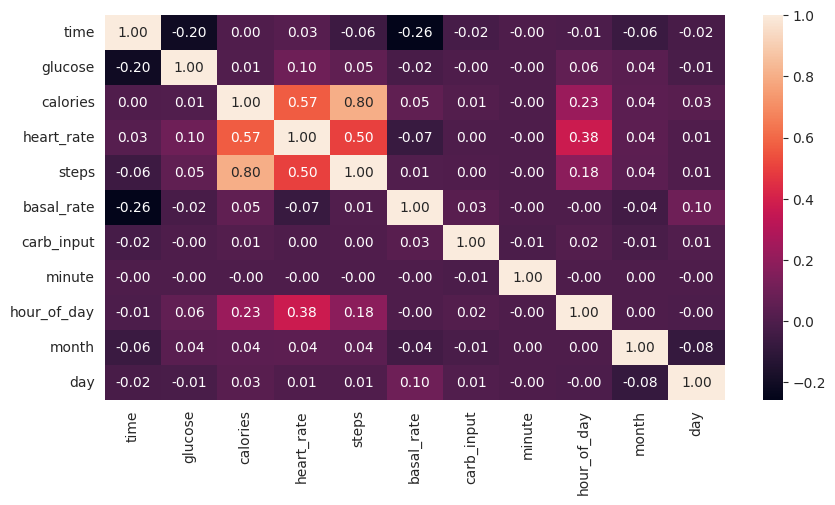

In [116]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.drop(columns=['bolus_volume_delivered', 'person_id']).corr(), annot=True, fmt='.2f')

In [23]:
df.describe()

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,minute,hour_of_day,month,day
count,309380,309380.000000,309380.000000,309380.000000,309380.000000,309380.000000,309380.000000,309380.000000,309380.000000,309380.000000,309380.000000,309380.000000
mean,2020-09-24 13:47:21.650074624,141.422364,8.813729,76.991604,30.826201,0.041323,0.066060,0.052720,27.500598,11.522820,6.675564,15.832061
min,2018-06-13 18:40:00,40.000000,0.000000,40.195364,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2020-01-30 11:10:00,99.666667,5.846100,64.931389,0.000000,0.000000,0.000000,0.000000,15.000000,6.000000,4.000000,8.000000
50%,2020-10-31 17:22:30,132.000000,6.278100,75.419499,0.000000,0.056000,0.000000,0.000000,30.000000,12.000000,7.000000,16.000000
75%,2021-07-27 06:46:15,173.000000,9.193060,85.612903,11.000000,0.066000,0.000000,0.000000,41.250000,18.000000,9.000000,23.000000
max,2022-05-18 12:15:00,444.000000,106.350000,195.615385,842.000000,0.250000,19.800000,130.000000,55.000000,23.000000,12.000000,31.000000
std,NaN,57.084015,6.930534,15.544863,84.982540,0.036106,0.755089,1.505462,17.259838,6.924846,3.232641,8.651156


In [11]:
# Histogram/Chart for all columns (total amount of data)
counts = df.count()
counts

time                      309380
glucose                   309380
calories                  309380
heart_rate                309380
steps                     309380
basal_rate                309380
bolus_volume_delivered    309380
carb_input                309380
person_id                 309380
minute                    309380
hour_of_day               309380
month                     309380
day                       309380
dtype: int64

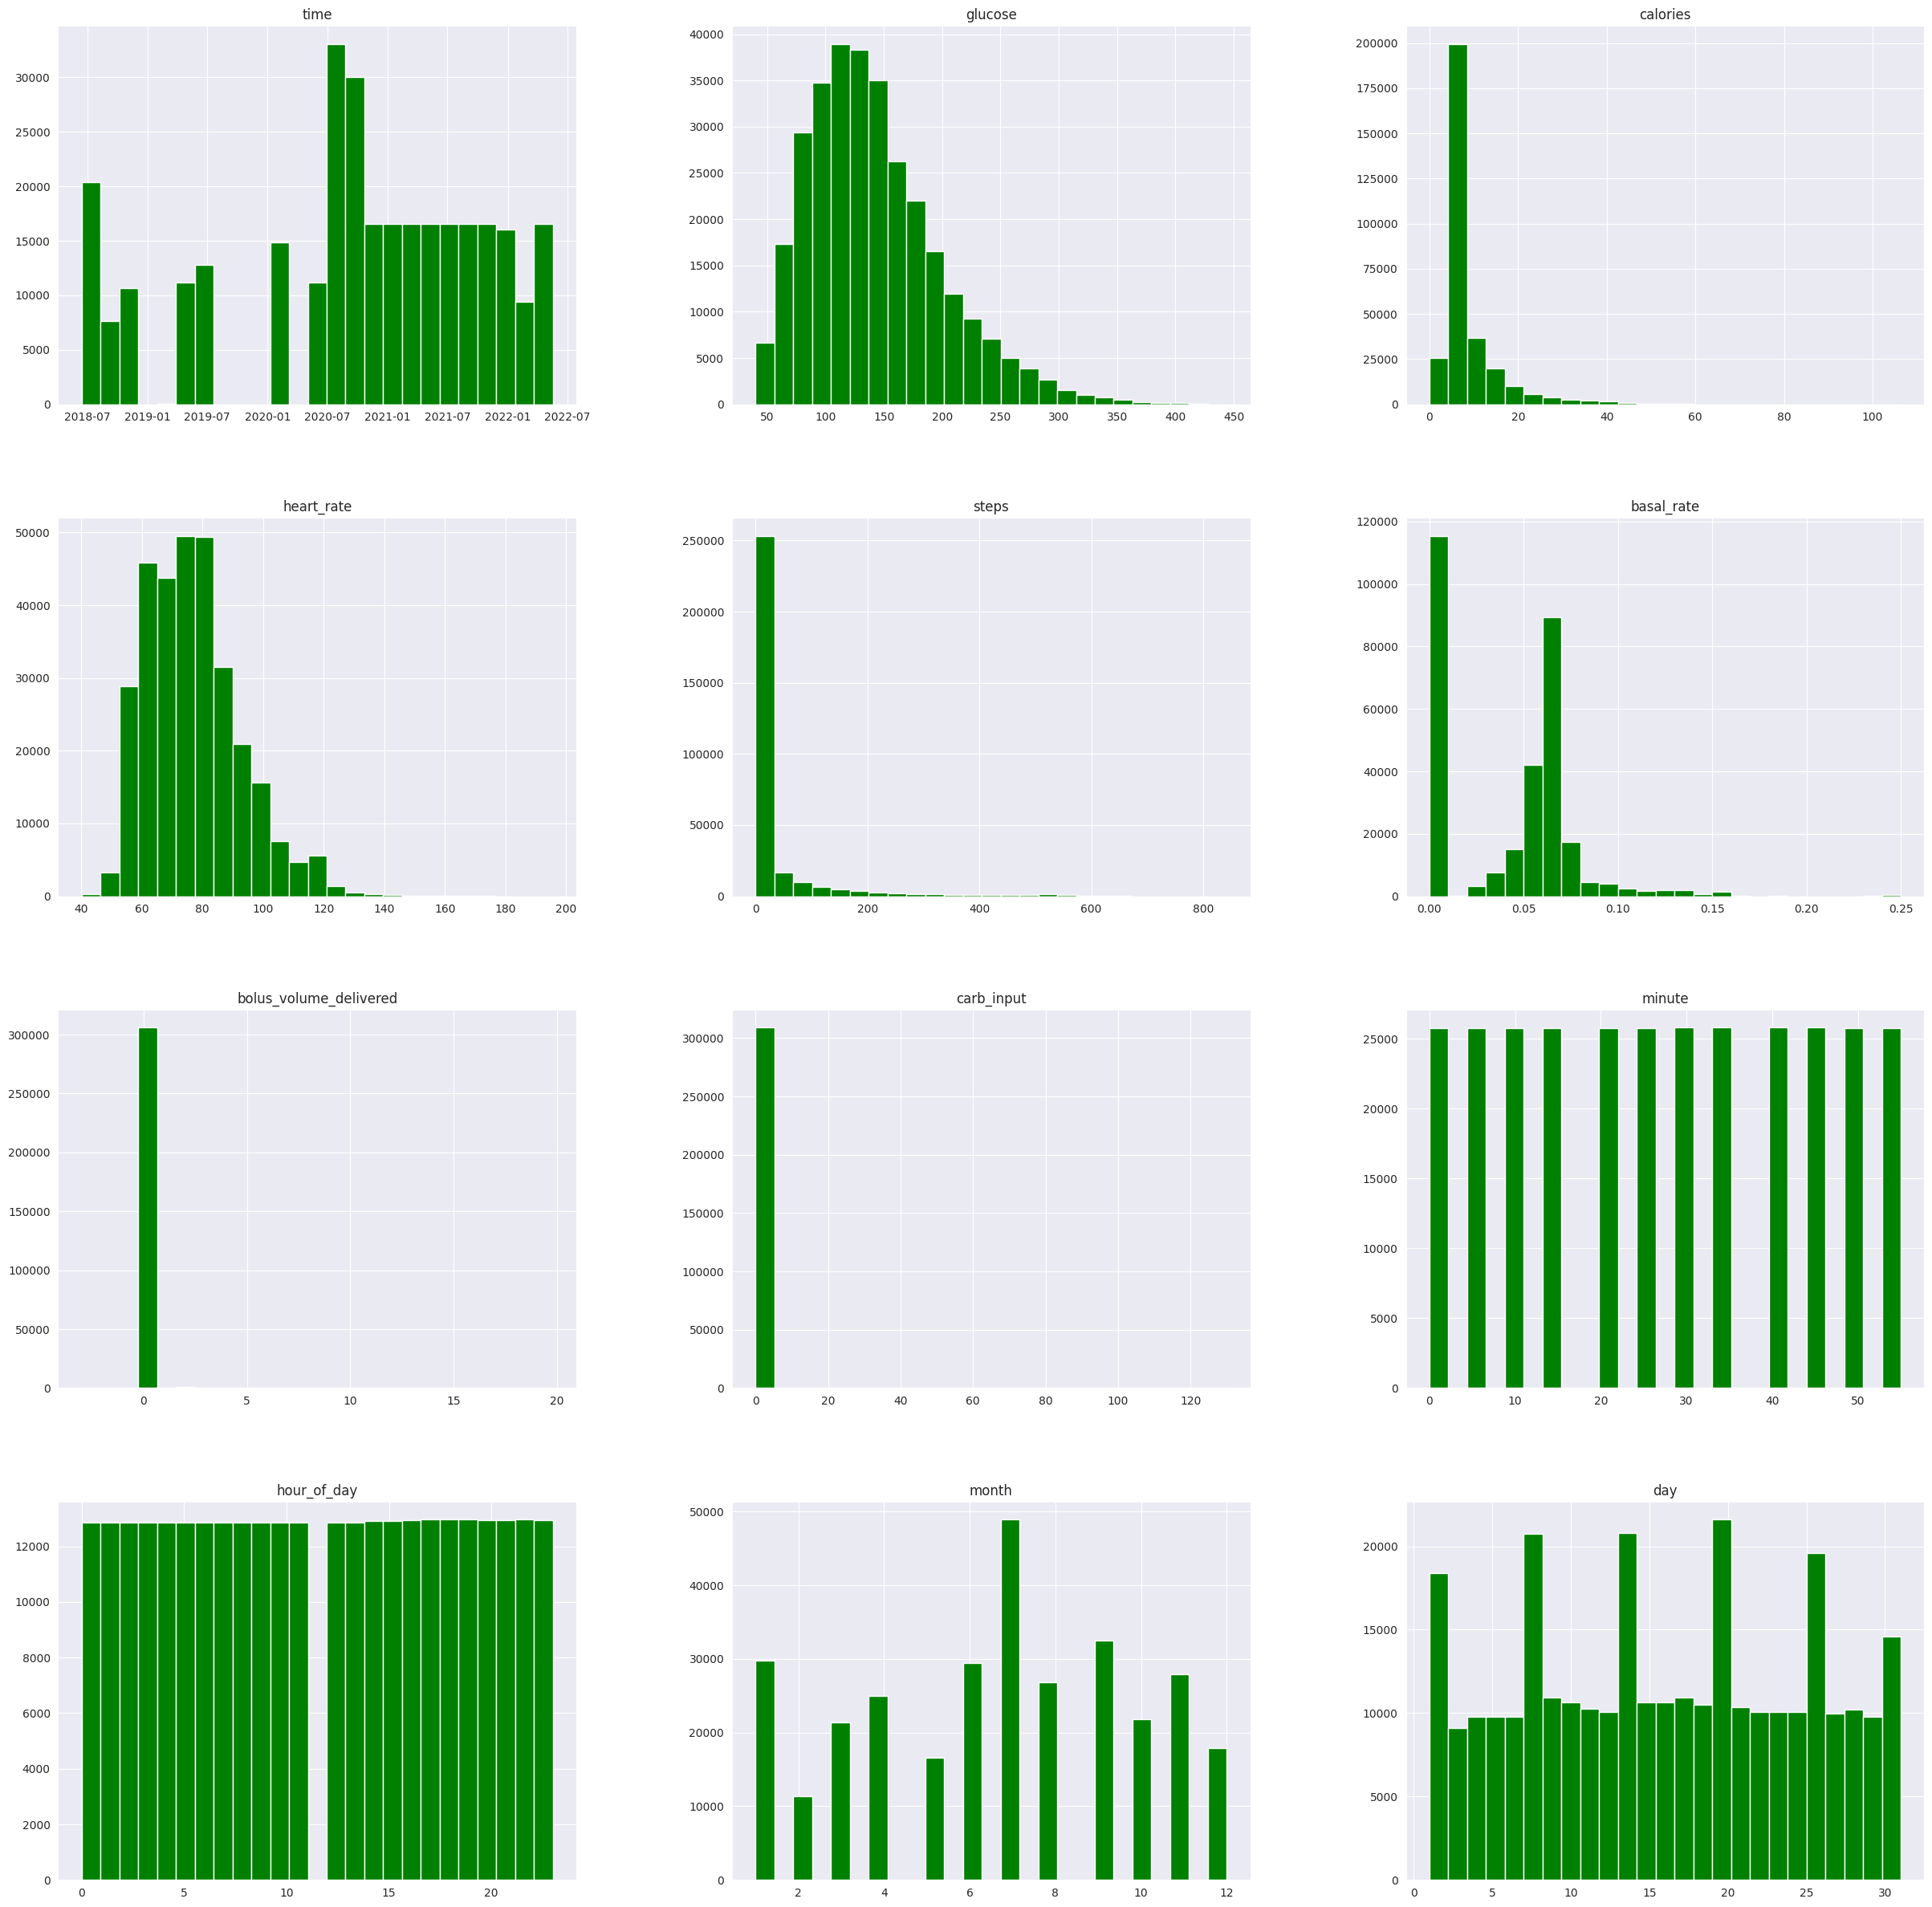

In [18]:
df.hist(bins=25, figsize=(30, 30), color='green')
plt.show()

## Define features

In [22]:
features = [
    'glucose', 'calories', 'heart_rate', 'steps',
    'bolus_volume_delivered', 'carb_input', 'minute',
    'hour_of_day', 'month', 'day',
]
print(features)

['glucose', 'calories', 'heart_rate', 'steps', 'bolus_volume_delivered', 'carb_input', 'minute', 'hour_of_day', 'month', 'day']


In [23]:
X = df[features]
y = df['basal_rate']

# SMOGN

In [34]:
df_smogn = smogn.smoter(
    data=df.sample(n=50000, random_state=42).reset_index(drop=True),
    # data=df, # Original data frame with data
    y='basal_rate', # Target variable (what to balance)
    k=5, # Number of neighbors to generate new points
    pert=0.02, # Percentage of noise added to new data
    samp_method="balance", # Balancing method ("balance" or "extreme")
    under_samp=True # Whether to further reduce the number of frequent values
)

X_smogn = df_smogn[features]
y_smogn = df_smogn['basal_rate']

r_index: 100%|##########| 835/835 [00:00<00:00, 1276.53it/s]
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/smogn/over_sampling.py:439: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        HUPA0026P
1        HUPA0026P
2        HUPA0026P
3        HUPA0026P
4        HUPA0026P
           ...    
23268          5.0
23269          7.0
23270          4.0
23271         10.0
23272          7.0
Name: 8, Length: 23273, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_new.iloc[:, j] = data_new.iloc[:, j].replace(x, cat_list[x])


In [ ]:
# reset_index(drop=True) is like renumbering the pages in a new book. Without it, SMOGN can get "lost" and crash with an error. This is standard practice when working with subselects in Pandas.
# we set df.sample(n=50000, random_state=42).reset_index(drop=True) instead of df

## Now calculating summary statistics for each of the columns

In [119]:
summary = df[features].describe().transpose()

# Predict dose

In [38]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Predict dose (SMOGN)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_smogn, y_smogn, test_size=0.2, random_state=42)

## Data scaling

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOGN (DT)

In [43]:
model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'Decision Tree. Mean Squared Error: {mse_rounded}')
print(f'Decision Tree. R²: {r2_rounded}')
print(f'Decision Tree. Mean Absolute Error: {mae_rounded}')

Decision Tree. Mean Squared Error: 0.001304
Decision Tree. R²: 0.783145
Decision Tree. Mean Absolute Error: 0.017981


# SMOGN (RF)

In [44]:
model = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'Random Forest. Mean Squared Error: {mse_rounded}')
print(f'Random Forest. R²: {r2_rounded}')
print(f'Random Forest. Mean Absolute Error: {mae_rounded}')

Random Forest. Mean Squared Error: 0.000748
Random Forest. R²: 0.875645
Random Forest. Mean Absolute Error: 0.017215


# SMOGN (XGB)

In [45]:
model = XGBRegressor(n_estimators=800, subsample=1.0, reg_lambda=1, reg_alpha=0.1, max_depth=14, learning_rate=0.05,
                     gamma=0, colsample_bytree=0.6)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'XGB. Mean Squared Error: {mse_rounded}')
print(f'XGB. R²: {r2_rounded}')
print(f'XGB. Mean Absolute Error: {mae_rounded}')

XGB. Mean Squared Error: 0.000717
XGB. R²: 0.880773
XGB. Mean Absolute Error: 0.018702


# SMOGN (LR)

In [49]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'Random Forest. Mean Squared Error: {mse_rounded}')
print(f'Random Forest. R²: {r2_rounded}')
print(f'Random Forest. Mean Absolute Error: {mae_rounded}')

Random Forest. Mean Squared Error: 0.005121
Random Forest. R²: 0.148297
Random Forest. Mean Absolute Error: 0.058476


# SMOGN (KNN)

In [48]:
model = KNeighborsRegressor(weights='distance', n_neighbors=7, metric='manhattan')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'KNN. Mean Squared Error: {mse_rounded}')
print(f'KNN. R²: {r2_rounded}')
print(f'KNN. Mean Absolute Error: {mae_rounded}')

KNN. Mean Squared Error: 0.001589
KNN. R²: 0.735658
KNN. Mean Absolute Error: 0.025538


# GMM

In [122]:
# Augmentation (10% of original size for large dataset)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_train_scaled)
percentage_quan_sample = 0.1
X_augmented, _ = gmm.sample(n_samples=int(percentage_quan_sample * len(X_train_scaled)))  # 10% of the original volume

# Data Merging
X_final = np.vstack([X_train_scaled, X_augmented])
y_final = np.concatenate([y_train, y_train[:len(X_augmented)]])

### RF

In [130]:
model = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42)
model.fit(X_final, y_final)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'Random Forest. Mean Squared Error: {mse_rounded}')
print(f'Random Forest. R²: {r2_rounded}')
print(f'Random Forest. Mean Absolute Error: {mae_rounded}')

Random Forest. Mean Squared Error: 0.00017
Random Forest. R²: 0.868998
Random Forest. Mean Absolute Error: 0.005879


### DT

In [134]:
# Pipeline is a short construction instead of below code
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('model', DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42))
# ])
model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
model.fit(X_final, y_final)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'Decision Tree. Mean Squared Error: {mse_rounded}')
print(f'Decision Tree. R²: {r2_rounded}')
print(f'Decision Tree. Mean Absolute Error: {mae_rounded}')

Decision Tree. Mean Squared Error: 0.000321
Decision Tree. R²: 0.752899
Decision Tree. Mean Absolute Error: 0.006797


### KNN

In [132]:
model = KNeighborsRegressor(weights='distance', n_neighbors=7, metric='manhattan')
model.fit(X_final, y_final)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'KNN. Mean Squared Error: {mse_rounded}')
print(f'KNN. R²: {r2_rounded}')
print(f'KNN. Mean Absolute Error: {mae_rounded}')

Random Forest. Mean Squared Error: 0.000526
Random Forest. R²: 0.595223
Random Forest. Mean Absolute Error: 0.015955


### XGB

In [137]:
model = XGBRegressor(n_estimators=800, subsample=1.0, reg_lambda=1, reg_alpha=0.1, max_depth=14, learning_rate=0.05,
                     gamma=0, colsample_bytree=0.6)
model.fit(X_final, y_final)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'XGB. Mean Squared Error: {mse_rounded}')
print(f'XGB. R²: {r2_rounded}')
print(f'XGB. Mean Absolute Error: {mae_rounded}')

Random Forest. Mean Squared Error: 0.000231
Random Forest. R²: 0.822281
Random Forest. Mean Absolute Error: 0.00954


### LR

In [135]:
model = LinearRegression()
model.fit(X_final, y_final)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'Random Forest. Mean Squared Error: {mse_rounded}')
print(f'Random Forest. R²: {r2_rounded}')
print(f'Random Forest. Mean Absolute Error: {mae_rounded}')

Random Forest. Mean Squared Error: 0.001263
Random Forest. R²: 0.027943
Random Forest. Mean Absolute Error: 0.031077


### Augmentation data (FOMA)

In [125]:
# def foma_augmentation(X, y, alpha=0.1, n_samples=100):
#     idx = np.random.choice(len(X), size=n_samples, replace=True)
#
#     X_selected = X[idx]
#     y_selected = y.iloc[idx].values
#
#     noise = alpha * np.random.randn(*X_selected.shape)
#     X_augmented = X_selected + noise
#
#     y_augmented = y_selected + alpha * np.random.randn(n_samples)
#
#     return np.vstack([X, X_augmented]), np.hstack([y, y_augmented])
#
#
# X_train_aug, y_train_aug = foma_augmentation(X_train_scaled, y_train)
#
# model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
# model.fit(X_train_aug, y_train_aug)
#
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# print(f'Decision Tree. Mean Squared Error: {round(mse, 6)}')
# print(f'Decision Tree. R²: {round(r2, 6)}')
# print(f'Decision Tree. Mean Absolute Error: {round(mae, 6)}')

### Augmentation data (FOMA)

In [126]:
# def foma_augmentation(X, y, alpha=0.1, n_samples=100):
#     idx = np.random.choice(len(X), size=n_samples, replace=True)
#
#     X_selected = X[idx]
#     y_selected = y.iloc[idx].values
#
#     noise = alpha * np.random.randn(*X_selected.shape)
#     X_augmented = X_selected + noise
#
#     y_augmented = y_selected + alpha * np.random.randn(n_samples)
#
#     return np.vstack([X, X_augmented]), np.hstack([y, y_augmented])
#
#
# X_train_aug, y_train_aug = foma_augmentation(X_train_scaled, y_train)
#
# model = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42)
# model.fit(X_train_aug, y_train_aug)
#
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# print(f'Random Forest. Mean Squared Error: {round(mse, 6)}')
# print(f'Random Forest. R²: {round(r2, 6)}')
# print(f'Random Forest. Mean Absolute Error: {round(mae, 6)}')

### DT model creation, training and evaluation (with augmentation)

In [127]:
# model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
# model.fit(X_train_scaled, y_train)
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'Decision Tree. Mean Squared Error: {mse_rounded}')
# print(f'Decision Tree. R²: {r2_rounded}')
# print(f'Decision Tree. Mean Absolute Error: {mae_rounded}')

### Without augmentation

## DT

In [128]:
# model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
# model.fit(X_train_scaled, y_train)
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'Decision Tree. Mean Squared Error: {mse_rounded}')
# print(f'Decision Tree. R²: {r2_rounded}')
# print(f'Decision Tree. Mean Absolute Error: {mae_rounded}')

### RF

In [129]:
# model = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42)
# model.fit(X_train_scaled, y_train)
#
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'Random Forest. Mean Squared Error: {mse_rounded}')
# print(f'Random Forest. R²: {r2_rounded}')
# print(f'Random Forest. Mean Absolute Error: {mae_rounded}')